# Task 3 - Convolutional Neural Network

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

In [ ]:
#
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [ ]:
class VanillaNN(nn.Module):
    
    def __init__(self, num_classes=10):
        super(VanillaNN, self).__init__()
        #First unit of convolution
        self.network = nn.Sequential(
            
            ## FEATURE LEARNING ##
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14x14x64
      
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 7 x 7 x 64

            ## CLASSIFICATION ##
            nn.Flatten(),

            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1))

    def forward(self, x):
        return self.network(x)



In [ ]:
class NeuralNetwork():
    
    def __init__(self, nn):
        self.nn = nn
    
    def initialise(self, loss_function, optimizer):
    
        self.loss_function = loss_function
        self.optimizer = optimizer
        
    def fit(self, data_loader, max_epochs):
        
        L_history = []
                       
        for epoch in range(max_epochs):

            self.nn.train()
            
            L_batch = 0.0
            
            for data, target in data_loader:
                
                data = data.to(device)
                target = target.to(device)
            
                # Set gradients to zero
                self.optimizer.zero_grad()
    
                # Forward pass
                output = self.nn(data)
    
                # Compute loss 
                L = self.loss_function(output, target)
    
                # Backward pass
                L.backward()
        
                # Weights update
                self.optimizer.step()
                
                L_batch += L.item() * data.size(0)
                
    
            L_history.append(L_batch/len(data_loader.sampler))
        

        self.L_history = L_history
        
    def predict(self, data_loader):
        
        self.nn.eval()
        
        y_pred = torch.LongTensor()
        y_test = torch.LongTensor()
        
        for data, target in data_loader:

            if torch.cuda.is_available():
              data = data.cuda()
            
            batch_output = self.nn(data)
            
            # Take the index with highest probability
            batch_preds = batch_output.cpu().data.max(1,keepdim=True)[1]
            
            #Combine tensors from each batch
            y_pred = torch.cat((y_pred, batch_preds), dim=0)
            
            y_test = torch.cat((y_test, target), dim=0)
            
            return y_pred, y_test
        
        #print("Accuracy: %.2f" % test)
        #print("\n")
        
        #fig, ax = plt.subplots(figsize = (5,5))
        #ax.plot(self.L_history)
        #ax.set_xlabel("Epochs")
        #ax.set_ylabel("Loss")
    

## Data set

Import data set:

*Source*: https://www.kaggle.com/datasets/zalando-research/fashionmnist

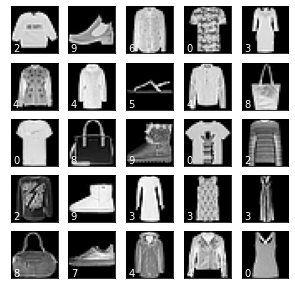

In [ ]:
# Import the data sets
path = "../data/fashon_MNIST/"
train = pd.read_csv("/content/drive/MyDrive/fashion-mnist_train.csv")
test = pd.read_csv("/content/drive/MyDrive/fashion-mnist_test.csv")

y_train = train["label"].values
y_test = test["label"].values

X_train = (train.iloc[:,1:].values).astype('float32')
X_test = (test.iloc[:,1:].values).astype('float32')

# Display some images
fig, axes = plt.subplots(5,5, figsize=(5, 5),subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    ax.text(0.05, 0.05, str(y_train[i]),  # type: ignore
            transform=ax.transAxes, color='white')
    
# Reshape and normalise the data
X_train = X_train.reshape(X_train.shape[0],1, 28, 28) / 255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28) / 255

Preprocess data for PyTorch:

In [ ]:
# Create tensor
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#y_train_tensor = F.one_hot(y_train_tensor, num_classes=10)
#y_test_tensor = F.one_hot(y_test_tensor, num_classes=10)

# Create TensorDatasets
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
test_tensor = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_tensor, batch_size=8000, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=8000, shuffle=True)

## Neural network

**Vanilla CNN**:

- 1st Convolution: 32@3x3 filter, stride 1, padding = 1
- Activation function: ReLu
- 2nd Convolution: 64@5x5 filter, stride 1, padding = 2
- Activation function: ReLu
- Max Pooling: 2x2 filter, stride 2
----------------------
- 3rd Convolution: 128@3x3 filter, stride 1, padding = 1
- Activation function: ReLu
- 4th Convolution: 64@5x5 filter, stride 1, padding = 2
- Activation function: ReLu
- Max Pooling: 2x2 filter, stride 2
----------------------
- Flatten the output for fully connected layer
- 3 dense layers (3136 input nodes, 128  hidden nodes, 10 output nodes) 



In [ ]:
# Vanilla neural network, a first application of a CNN
VanillaNN = VanillaNN().to(device)

## Solution

Define different structures for the neural network:

Solve the neural network:

In [ ]:
for _ in range(4):
  NN = NeuralNetwork(VanillaNN)
  NN.initialise(loss_function = nn.CrossEntropyLoss(), optimizer = torch.optim.Adam(VanillaNN.parameters(),lr= 0.001) )
  NN.fit(train_loader, max_epochs = 50)
  y_pred, y_test = NN.predict(test_loader)
  print("Accuracy: %.2f"%accuracy_score(y_pred, y_test))

Accuracy: 0.80
Accuracy: 0.91
Accuracy: 0.92
Accuracy: 0.92


L'accuracy è normale che varia perchè con il mini batch stai prendendo dei subset diversi e quindi ogni dataset darò un diverso valore della direzione in cui muoversi per la discesa. Quindi in questo caso, ci sono due approcci, utilizzare un decay/un ADAM optimizer o comunque ridurre il learning rate

## CNN layers

**Filters**:
- Number of filters K (2,4, order of 2)
- Filter size F (odd mostly, 3, 5 )
- Stride S (mostly one)
- Padding amount P

**Pooling**:
- F = 2, 3
- S = 1 , 2

class NeuralNetwork_OLD():
    
    def __init__(self, nn):
        self.nn = nn
    
    def initialise(self, loss_function, optimizer):
    
        self.loss_function = loss_function
        self.optimizer = optimizer
        
    def fit(self, X, y, max_epochs, n_mini_batches):
        
        L_history = []
                
        # Create batches of mini-batch training
        batch_size = int(len(X)/n_mini_batches) # batch dimension
        batches = [range(x,min(x+batch_size,len(X))) for x in range(0, len(X), batch_size)]
        
        for epoch in range(max_epochs):
            
            # Shuffle data
            shuffle_indices = np.arange(len(X))
            np.random.shuffle(shuffle_indices)
            X = X[shuffle_indices]
            y = y[shuffle_indices] 
            
            L_batch = 0.0 
            
            for batch in batches: # Train each batch independently 
                
                # Select batches
                X_batch = X[batch]
                y_batch = y[batch]

                # Set gradients to zero
                self.optimizer.zero_grad()
    
                # Forward pass
                output = self.nn(X_batch)
    
                # Compute loss 
                L = self.loss_function(output, y_batch)
    
                # Backward pass
                L.backward()
        
                # Weights update
                self.optimizer.step()
                
                L_batch += L.item() * batch_size
    
            L_history.extend([L_batch])

        self.L_history = L_history
        
    def evaluate(self, X, y):
        
        
        y_pred = self.nn(X)
        a =np.where(y_pred>0.5,1,0)
        test = sum(a == y.numpy())/len(y)
        
        print("Accuracy: %.2f" % test)
        print("\n")
        
        fig, ax = plt.subplots(figsize = (5,5))
        ax.plot(self.L_history)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
    